In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import dask.dataframe as dd
from utils import uv_to_wsd

INPUT_PATH = "../input/"

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 데이터 체크

In [2]:
# 터빈 개수가 적은 경주풍력에 대해서만 한번 진행
power = pd.read_parquet(INPUT_PATH + "dynamic_report_ewp02_2020_10min.parquet").rename({'Date/Time': 'dt'}, axis=1)
gj_y = pd.read_parquet(INPUT_PATH + "train_y.parquet").rename({'end_datetime': 'dt'}, axis=1)
ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")

print("Power: ", power.shape)
print("train_y: ", gj_y.shape)
print("LDAPS: ", ldaps.shape)

Power:  (52592, 29)
train_y:  (52608, 4)
LDAPS:  (235818, 15)


In [3]:
power['WTG.Name'].nunique()

1

In [4]:
power[(power['EnergyProductionActiveEnergyProduction[KWh]'] == 0)].shape

(10997, 29)

In [5]:
availability_cols = power.columns[power.columns.str.contains('Availability')]
tmp = power[(power['EnergyProductionActiveEnergyProduction[KWh]'] == 0)][availability_cols].sum(axis=1)
len(tmp.loc[tmp == 0]) / len(power[(power['EnergyProductionActiveEnergyProduction[KWh]'] == 0)])

0.5077748476857324

In [6]:
# data slicing
power = power[:-3]

datas = [power, gj_y, ldaps]
for d in datas:
    try:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_convert("Asia/Seoul"))
    except TypeError:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_localize("Asia/Seoul"))

gj_y = (gj_y.loc[(gj_y['plant_name'] == "경주풍력")
                 & (gj_y['dt']).between('2020-01-01', '2021-01-01', inclusive='left')])

ldaps = ldaps.loc[ldaps['dt'].between('2020-01-01', '2021-01-01', inclusive='left')]

print("Power: ", power.shape, power['dt'].min(), power['dt'].max())
print("train_y: ", gj_y.shape, gj_y['dt'].min(), gj_y['dt'].max())
print("LDAPS: ", ldaps.shape, ldaps['dt'].min(), ldaps['dt'].max())

Power:  (52589, 29) 2020-01-01 00:00:00+09:00 2020-12-31 23:50:00+09:00
train_y:  (8783, 4) 2020-01-01 01:00:00+09:00 2020-12-31 23:00:00+09:00
LDAPS:  (78840, 15) 2020-01-02 00:00:00+09:00 2020-12-31 23:00:00+09:00


시간 간격
* dt_power = 10분 -> 6 * 24 * 366 = 52704 (2020년에는 2월이 29일이다.) 365일일때는 52560인데, 데이터가 수집이 안된 경우가 있는듯
* dt_train_y = 1시간 -> 24 * 366  = 8784 (train_y는 01시부터 시작이므로 1개를 빼면 맞음)
* dt_ldaps = 1시간 -> 24 * 366 * 9(turbine수) = 79056 (24 * 265 * 9로 했을때 데이터 개수가 맞음)

In [7]:
power['dt']

0       2020-01-01 00:00:00+09:00
1       2020-01-01 00:10:00+09:00
2       2020-01-01 00:20:00+09:00
3       2020-01-01 00:30:00+09:00
4       2020-01-01 00:40:00+09:00
                   ...           
52584   2020-12-31 23:10:00+09:00
52585   2020-12-31 23:20:00+09:00
52586   2020-12-31 23:30:00+09:00
52587   2020-12-31 23:40:00+09:00
52588   2020-12-31 23:50:00+09:00
Name: dt, Length: 52589, dtype: datetime64[ns, Asia/Seoul]

경주에는 현재 데이터 상으로 9개 터빈 존재.
- power : 1개 터빈만 있음.
- ldaps : 9개 터빈

In [9]:
print("Power: ", power['WTG.Name'].nunique(), power['WTG.Name'].unique())
print("LDAPS: ", ldaps['turbine_id'].nunique(), ldaps['turbine_id'].unique())

Power:  1 ['WTG01']
LDAPS:  9 ['WTG01' 'WTG02' 'WTG03' 'WTG04' 'WTG05' 'WTG06' 'WTG07' 'WTG08' 'WTG09']


* actualpower가 터빈 하나당 y값인가?
- 그건 아닌데 상관관계가 매우 높음

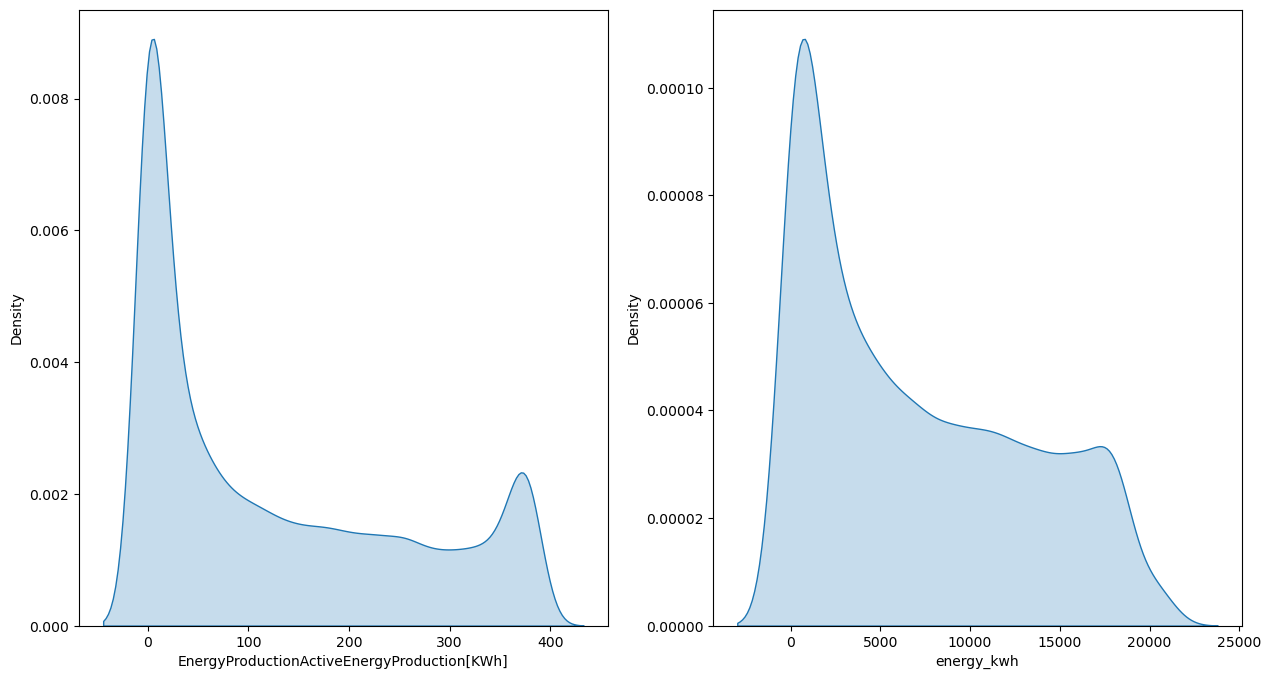

In [6]:
plt.figure(figsize=(15,8))
ax = plt.subplot(1, 2, 1)
sns.kdeplot(data=power,
            x='EnergyProductionActiveEnergyProduction[KWh]',
            fill=True,
            ax=ax)

ax2 = plt.subplot(1, 2, 2)
sns.kdeplot(data=gj_y,
            x='energy_kwh',
            fill=True, 
            ax=ax2)
plt.show()

In [7]:
from scipy.stats import pearsonr
tmp = pd.merge(gj_y, power[['dt', 'EnergyProductionActiveEnergyProduction[KWh]']],
               how='inner', on='dt')

pearsonr(tmp['EnergyProductionActiveEnergyProduction[KWh]'], tmp['energy_kwh'])

PearsonRResult(statistic=0.8278242889898189, pvalue=0.0)

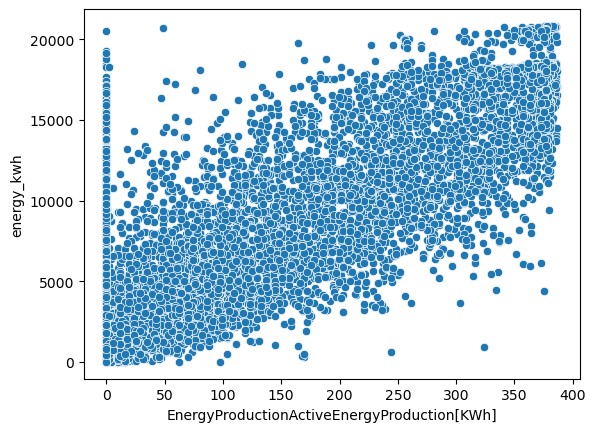

In [8]:
sns.scatterplot(data=tmp,
                x='EnergyProductionActiveEnergyProduction[KWh]',
                y='energy_kwh')
plt.show()

In [9]:
tmp.head()

,plant_name,dt,period_hours,energy_kwh,EnergyProductionActiveEnergyProduction[KWh]
0,경주풍력,2020-01-01 01:00:00+09:00,1,9767.578125,0.000000
1,경주풍력,2020-01-01 02:00:00+09:00,1,5381.835938,0.000000
2,경주풍력,2020-01-01 03:00:00+09:00,1,3021.484375,0.000000
3,경주풍력,2020-01-01 04:00:00+09:00,1,4400.390625,137.695312
4,경주풍력,2020-01-01 05:00:00+09:00,1,4501.953125,0.000000


In [10]:
# 실제생산량에는 0이 많은 이유가?

# ActiveEnergyProduction에 0이 있는 이유
(가설)
* 점검 등의 기술적인 이유
* 단순히 풍속이 낮아서

In [11]:
power_0 = power.loc[power['EnergyProductionActiveEnergyProduction[KWh]'] == 0]
power_0.head()

,dt,WTG.Name,WTG.Serial,AvailabilityForcedOutageTime[Min.],AvailabilityFullPerformanceTime[Min.],AvailabilityRequestedShutdownTime[Min.],AvailabilityScheduledMaintenanceTime[Min.],AvailabilityTechnicalStandbyTime[Min.],EnergyProductionActiveEnergyProduction[KWh],GeneratorAverageWindingTemp.[℃],...,RotorBlade2Pos.[deg],RotorBlade3Pos.[deg],RotorMotor1Pos.[deg],RotorMotor2Pos.[deg],RotorMotor3Pos.[deg],RotorPitch1Angle[deg],RotorPitch2Angle[deg],RotorPitch3Angle[deg],RotorRotorSpeed[rpm],YawYawcablewindup[deg]
2,2020-01-01 00:20:00+09:00,WTG01,U113-001,0.0,0.033333,0.0,0.0,8.866667,0.0,83.386063,...,90.080002,90.000130,90.0,90.0,90.0,90.0,90.0,90.0,-0.004660,402.67984
3,2020-01-01 00:30:00+09:00,WTG01,U113-001,0.0,0.033333,0.0,0.0,3.300000,0.0,67.732239,...,90.080002,90.000031,90.0,90.0,90.0,90.0,90.0,90.0,0.004165,402.67984
4,2020-01-01 00:40:00+09:00,WTG01,U113-001,0.0,0.000000,0.0,0.0,0.000000,0.0,63.201435,...,90.080002,90.000031,90.0,90.0,90.0,90.0,90.0,90.0,0.001102,402.67984
5,2020-01-01 00:50:00+09:00,WTG01,U113-001,0.0,0.000000,0.0,0.0,0.000000,0.0,62.119621,...,90.080002,90.000000,90.0,90.0,90.0,90.0,90.0,90.0,-0.002322,402.67984
6,2020-01-01 01:00:00+09:00,WTG01,U113-001,0.0,0.000000,0.0,0.0,0.000000,0.0,61.640320,...,90.080132,89.996765,90.0,90.0,90.0,90.0,90.0,90.0,0.007092,402.67984


In [12]:
columns = power.columns[power.columns.str.contains('Grid')]
tmp = power[columns]

display(tmp.describe())

columns = power_0.columns[power_0.columns.str.contains('Grid')]
tmp = power_0[columns]

display(tmp.describe())

,GridActivePower[kW],GridReactivePower[kVAr]
count,52589.000000,52589.000000
mean,755.031677,85.632507
std,783.523560,43.738457
min,-30.025930,0.000000
25%,39.956017,82.197121
50%,451.648010,89.755180
75%,1378.048706,113.170723
max,2332.774414,169.270096


,GridActivePower[kW],GridReactivePower[kVAr]
count,10997.000000,10997.000000
mean,4.617043,12.882832
std,105.684616,13.447702
min,-30.025930,0.000000
25%,-2.133754,9.102040
50%,-1.320563,9.576470
75%,-0.924447,10.311216
max,2230.229248,152.743546


In [13]:
columns = power.columns[(power.columns.str.contains('Availability'))
                        | (power.columns == 'EnergyProductionActiveEnergyProduction[KWh]')]
tmp = power[columns]

display(tmp.describe())
display(tmp.corr().style.background_gradient())

,AvailabilityForcedOutageTime[Min.],AvailabilityFullPerformanceTime[Min.],AvailabilityRequestedShutdownTime[Min.],AvailabilityScheduledMaintenanceTime[Min.],AvailabilityTechnicalStandbyTime[Min.],EnergyProductionActiveEnergyProduction[KWh]
count,52589.000000,52589.000000,52589.000000,52589.000000,52589.000000,52589.000000
mean,0.295213,7.783504,0.378652,0.013200,0.188621,125.294128
std,1.661874,4.070228,1.884905,0.361123,1.055029,129.992203
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10.000000,0.000000,0.000000,0.000000,6.835938
50%,0.000000,10.000000,0.000000,0.000000,0.000000,74.218750
75%,0.000000,10.000000,0.000000,0.000000,0.000000,228.515625
max,10.000000,10.000000,10.000000,10.000000,10.000000,388.671875


,AvailabilityForcedOutageTime[Min.],AvailabilityFullPerformanceTime[Min.],AvailabilityRequestedShutdownTime[Min.],AvailabilityScheduledMaintenanceTime[Min.],AvailabilityTechnicalStandbyTime[Min.],EnergyProductionActiveEnergyProduction[KWh]
AvailabilityForcedOutageTime[Min.],1.000000,-0.334091,-0.025418,-0.006483,-0.019920,-0.167030
AvailabilityFullPerformanceTime[Min.],-0.334091,1.000000,-0.381757,-0.069582,-0.269284,0.493172
AvailabilityRequestedShutdownTime[Min.],-0.025418,-0.381757,1.000000,-0.007289,-0.027690,-0.192303
AvailabilityScheduledMaintenanceTime[Min.],-0.006483,-0.069582,-0.007289,1.000000,-0.005307,-0.035054
AvailabilityTechnicalStandbyTime[Min.],-0.019920,-0.269284,-0.027690,-0.005307,1.000000,-0.160800
EnergyProductionActiveEnergyProduction[KWh],-0.167030,0.493172,-0.192303,-0.035054,-0.160800,1.000000


In [14]:
# FullPerformanceTime이 그나마 연관이 있어보이는데, 오히려 점검, 보수 등 작동을 멈추는 것에 대한 얘기는 아닌듯 함.

In [21]:
from astral import LocationInfo
from astral.sun import sun
import pytz
import swifter


# day and night
location = LocationInfo("yeonggwang", "Korea", "Asia/Seoul", 35.25257837, 126.34227347)

def is_day_or_night(dt):
    s = sun(location.observer, date=dt)
    sunrise = s['sunrise']
    sunset = s['sunset']
#     dt = dt.tz_localize('Asia/Seoul')
    if sunrise < dt < sunset:
            return 0 # Day
    else:
            return 1 # Night.

ldaps['Night'] = ldaps['dt'].swifter.apply(lambda x : is_day_or_night(x))

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\jhk32\AppData\Local\Temp\ipykernel_7456\4223493672.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps['Night'] = ldaps['dt'].swifter.apply(lambda x : is_day_or_night(x))


# 변수별 상관계수 확인

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 13221 (\N{SQUARE M CUBED}) missing from current font.
  fig.canvas.draw()
c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13221 (\N{SQUARE M CUBED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


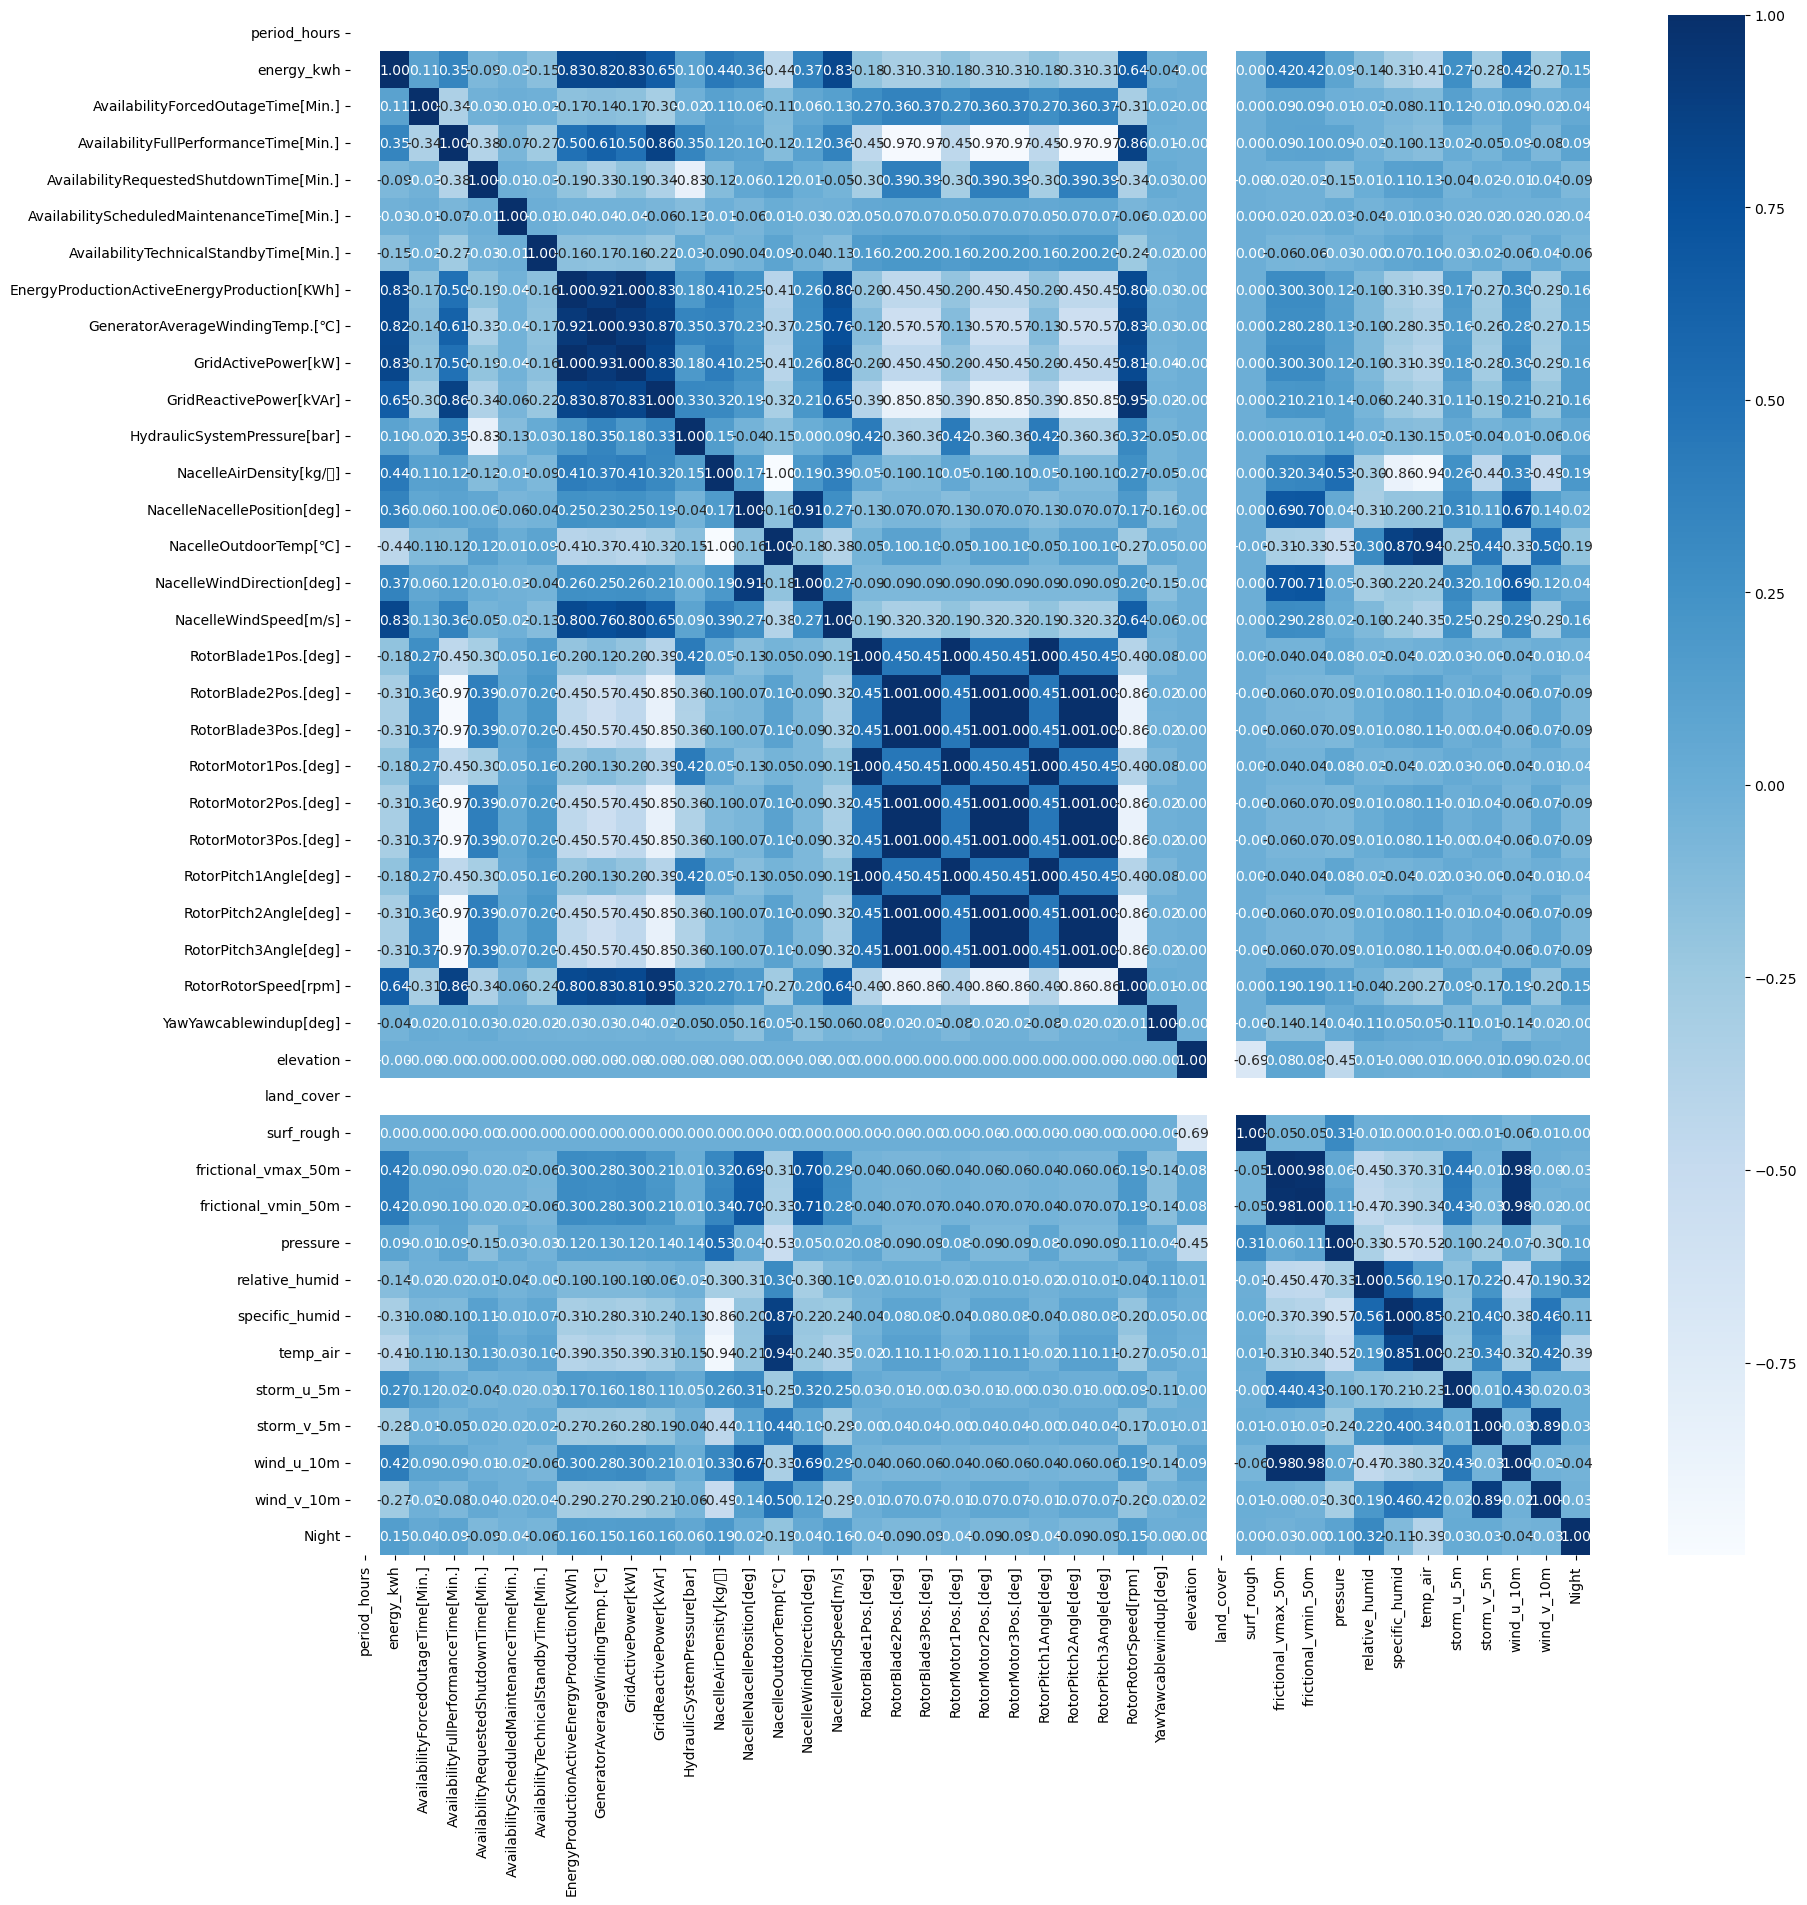

In [24]:
tmp = pd.merge(gj_y, power,
               how='inner', on='dt')

tmp = pd.merge(tmp, ldaps,
               how='inner', on='dt')

# (tmp.corr(numeric_only=True)
#  .style
#  .background_gradient())
plt.figure(figsize=(20,20))
sns.heatmap(data=tmp.corr(numeric_only=True),
            annot=True,
            fmt='.2f',
            cmap='Blues')

plt.show()

del tmp

In [43]:
power.head()

,dt,WTG.Name,WTG.Serial,AvailabilityForcedOutageTime[Min.],AvailabilityFullPerformanceTime[Min.],AvailabilityRequestedShutdownTime[Min.],AvailabilityScheduledMaintenanceTime[Min.],AvailabilityTechnicalStandbyTime[Min.],EnergyProductionActiveEnergyProduction[KWh],GeneratorAverageWindingTemp.[℃],...,RotorBlade2Pos.[deg],RotorBlade3Pos.[deg],RotorMotor1Pos.[deg],RotorMotor2Pos.[deg],RotorMotor3Pos.[deg],RotorPitch1Angle[deg],RotorPitch2Angle[deg],RotorPitch3Angle[deg],RotorRotorSpeed[rpm],YawYawcablewindup[deg]
0,2020-01-01 00:00:00+09:00,WTG01,U113-001,0.0,10.000000,0.0,0.0,0.000000,379.882812,92.984619,...,13.507234,13.473200,13.369333,13.370267,13.369933,13.369333,13.371600,13.369933,13.455300,402.67984
1,2020-01-01 00:10:00+09:00,WTG01,U113-001,0.0,7.233333,0.0,0.0,0.000000,300.781250,98.441666,...,23.934601,23.891001,23.818966,23.819099,23.819300,23.818966,23.819099,23.819300,11.564468,402.67984
2,2020-01-01 00:20:00+09:00,WTG01,U113-001,0.0,0.033333,0.0,0.0,8.866667,0.000000,83.386063,...,90.080002,90.000130,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,-0.004660,402.67984
3,2020-01-01 00:30:00+09:00,WTG01,U113-001,0.0,0.033333,0.0,0.0,3.300000,0.000000,67.732239,...,90.080002,90.000031,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,0.004165,402.67984
4,2020-01-01 00:40:00+09:00,WTG01,U113-001,0.0,0.000000,0.0,0.0,0.000000,0.000000,63.201435,...,90.080002,90.000031,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,0.001102,402.67984


In [49]:
for i in range(1, 4):
    same1 = sum(power[f'RotorBlade{i}Pos.[deg]'] == power[f'RotorPitch{i}Angle[deg]']) / power.shape[0] * 100
    same2 = sum(power[f'RotorBlade{i}Pos.[deg]'] == power[f'RotorMotor{i}Pos.[deg]']) / power.shape[0] * 100
    same3 = sum(power[f'RotorPitch{i}Angle[deg]'] == power[f'RotorMotor{i}Pos.[deg]']) / power.shape[0] * 100
    print(f"Blade{i} Pos/Pitch Similarity: ", same1)
    print(f"Blade{i} Pos/Motor Similarity: ", same2)
    print(f"Blade{i} Pitch/Motor Similarity: ", same3)
    print("-" * 50)

Blade1 Pos/Pitch Similarity:  3.2687444142311133
Blade1 Pos/Motor Similarity:  3.2725474909201546
Blade1 Pitch/Motor Similarity:  95.2632679837989
--------------------------------------------------
Blade2 Pos/Pitch Similarity:  1.6353229762878168
Blade2 Pos/Motor Similarity:  1.633421437943296
Blade2 Pitch/Motor Similarity:  91.11981593108825
--------------------------------------------------
Blade3 Pos/Pitch Similarity:  3.4741105554393505
Blade3 Pos/Motor Similarity:  3.4722090170948294
Blade3 Pitch/Motor Similarity:  97.60596322424841
--------------------------------------------------


In [23]:
# elevation, landcover, surf_rough는 상관성 없음
# Rotor blade1 등의 feature들은 서로 상관관계가 매우 높음
# grid_active, reactive power,energy production, winding temp끼리는 서로 상관관계가 매우 높음.
# rotor motor speed, nacelle wind speed, 바로 위에 상기한 feature들은 target값과 상관관계가 높음.
# 

# 변수를 추가해보자

In [39]:
ldaps.loc[:,'tke_5m'] = 0.5 * (ldaps['storm_u_5m'] ** 2 + ldaps['storm_v_5m'] ** 2)

ldaps.loc[:, 'storm/wind_u'] = ldaps['storm_u_5m'] / ldaps['wind_u_10m']
ldaps.loc[:, 'storm/wind_v'] = ldaps['storm_v_5m'] / ldaps['wind_v_10m']

ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
    ldaps["wind_u_10m"], ldaps["wind_v_10m"]
)

C:\Users\jhk32\AppData\Local\Temp\ipykernel_7456\1504128810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
C:\Users\jhk32\AppData\Local\Temp\ipykernel_7456\1504128810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(


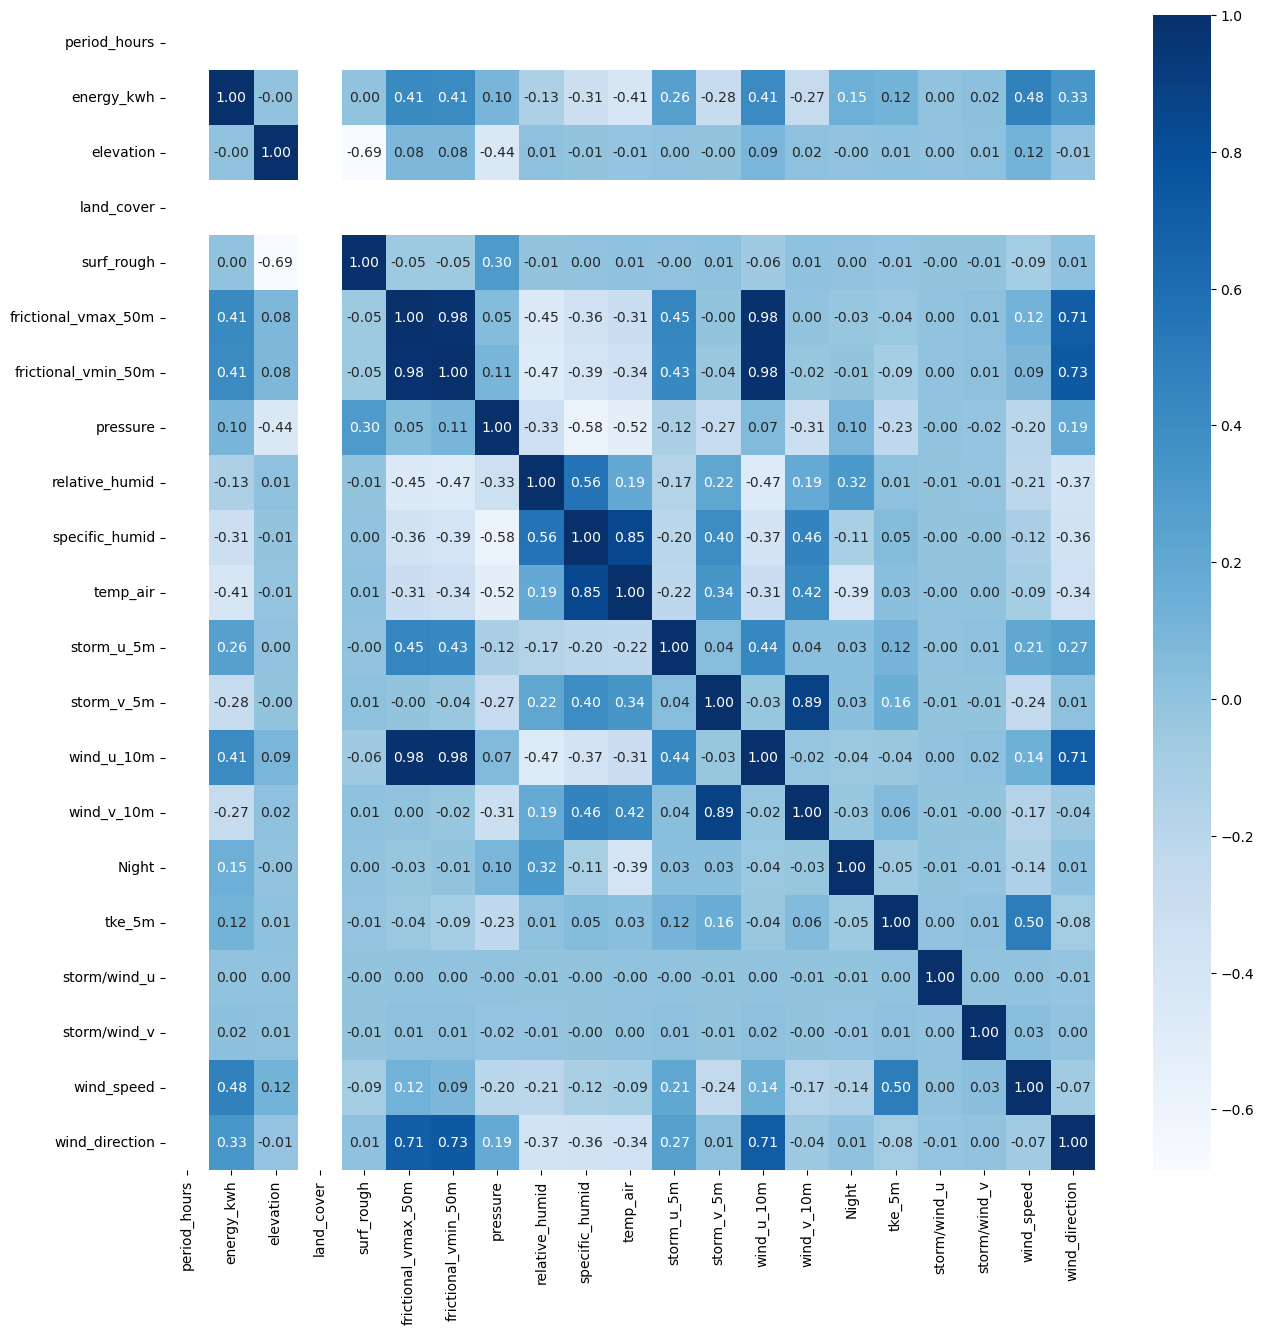

In [40]:
tmp = pd.merge(gj_y, ldaps,
               how='inner', on='dt')

plt.figure(figsize=(15,15))
sns.heatmap(data=tmp.corr(numeric_only=True, method='pearson'),
            annot=True,
            fmt='.2f',
            cmap='Blues')

plt.show()
del tmp

# scada와 ldaps 차이

### 1. wind speed

In [70]:
# 터빈 개수가 적은 경주풍력에 대해서만 한번 진행
power = pd.read_parquet(INPUT_PATH + "dynamic_report_ewp02_2020_10min.parquet").rename({'Date/Time': 'dt'}, axis=1)
power2 = pd.read_parquet(INPUT_PATH + "dynamic_report_ewp02_2021_10min.parquet").rename({'Date/Time': 'dt'}, axis=1)
gj_y = pd.read_parquet(INPUT_PATH + "train_y.parquet").rename({'end_datetime': 'dt'}, axis=1)
ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")

print("Power: ", power.shape)
print("train_y: ", gj_y.shape)
print("LDAPS: ", ldaps.shape)

Power:  (52592, 29)
train_y:  (52608, 4)
LDAPS:  (235818, 15)


In [71]:
# data slicing
power, power2 = power[:-3], power2[:-3]

datas = [power, power2, gj_y, ldaps]
for d in datas:
    try:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_convert("Asia/Seoul"))
    except TypeError:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_localize("Asia/Seoul"))

gj_y = (gj_y.loc[(gj_y['plant_name'] == "경주풍력")
                 & (gj_y['dt']).between('2020-01-01', '2021-01-01', inclusive='left')])

ldaps = ldaps.loc[ldaps['dt'].between('2020-01-01', '2021-01-01', inclusive='left')]

print("Power: ", power.shape, power['dt'].min(), power['dt'].max())
print("train_y: ", gj_y.shape, gj_y['dt'].min(), gj_y['dt'].max())
print("LDAPS: ", ldaps.shape, ldaps['dt'].min(), ldaps['dt'].max())

Power:  (52589, 29) 2020-01-01 00:00:00+09:00 2020-12-31 23:50:00+09:00
train_y:  (8783, 4) 2020-01-01 01:00:00+09:00 2020-12-31 23:00:00+09:00
LDAPS:  (78840, 15) 2020-01-02 00:00:00+09:00 2020-12-31 23:00:00+09:00


In [72]:
ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
    ldaps["wind_u_10m"], ldaps["wind_v_10m"]
)

power.rename({'WTG.Name': 'turbine_id'}, axis=1, inplace=True)
tmp = pd.merge(gj_y, power,
               how='inner', on=['dt'])

tmp = pd.merge(tmp, ldaps,
               how='inner', on=['dt', 'turbine_id'])

tmp.head()

C:\Users\jhk32\AppData\Local\Temp\ipykernel_16720\209884163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
C:\Users\jhk32\AppData\Local\Temp\ipykernel_16720\209884163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(


,plant_name,dt,period_hours,energy_kwh,turbine_id,WTG.Serial,AvailabilityForcedOutageTime[Min.],AvailabilityFullPerformanceTime[Min.],AvailabilityRequestedShutdownTime[Min.],AvailabilityScheduledMaintenanceTime[Min.],...,pressure,relative_humid,specific_humid,temp_air,storm_u_5m,storm_v_5m,wind_u_10m,wind_v_10m,wind_speed,wind_direction
0,경주풍력,2020-01-02 00:00:00+09:00,1,17827.148438,WTG01,U113-001,0.0,10.0,0.0,0.0,...,97974.593750,91.796478,0.002686,269.467560,0.021201,-0.375756,7.353266,-2.640615,7.813025,289.753601
1,경주풍력,2020-01-02 01:00:00+09:00,1,17616.210938,WTG01,U113-001,0.0,10.0,0.0,0.0,...,97970.132812,91.729774,0.002686,269.430847,0.020706,-0.371947,7.578446,-2.414076,7.953654,287.669006
2,경주풍력,2020-01-02 02:00:00+09:00,1,17904.296875,WTG01,U113-001,0.0,10.0,0.0,0.0,...,97951.546875,92.788666,0.002686,269.374390,0.020556,-0.354397,7.654554,-2.259913,7.981191,286.448578
3,경주풍력,2020-01-02 03:00:00+09:00,1,17676.757812,WTG01,U113-001,0.0,10.0,0.0,0.0,...,97908.968750,92.494576,0.002686,269.352112,0.021635,-0.328609,7.275844,-2.280371,7.624827,287.401855
4,경주풍력,2020-01-02 04:00:00+09:00,1,18519.531250,WTG01,U113-001,0.0,10.0,0.0,0.0,...,97858.398438,88.986443,0.002686,269.413269,0.024231,-0.265124,6.911751,-1.920128,7.173506,285.525635


                       wind_speed  NacelleWindSpeed[m/s]
wind_speed               1.000000               0.710568
NacelleWindSpeed[m/s]    0.710568               1.000000


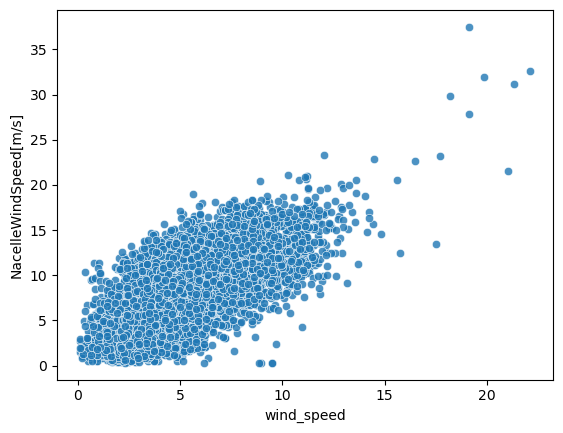

In [74]:
print(tmp[['wind_speed', 'NacelleWindSpeed[m/s]']].corr())

sns.scatterplot(data=tmp,
                x='wind_speed', y='NacelleWindSpeed[m/s]',
                alpha=0.8, sizes=30)
plt.show()

In [ ]:
from windpowerlib.wind_speed import logarithmic_profile

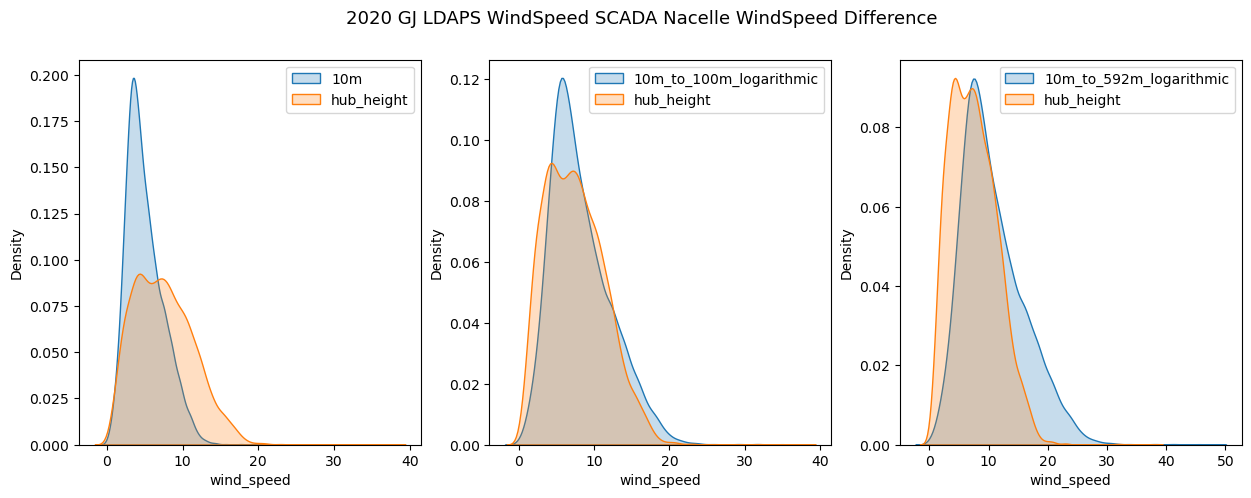

In [148]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
sns.kdeplot(data=tmp,
            x='wind_speed', label='10m',
            fill=True, ax=ax1)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True, ax=ax1)
ax1.legend()

log_speed = logarithmic_profile(tmp['wind_speed'], 10, 100, 0.286911)

ax2 = plt.subplot(1, 3, 2)
sns.kdeplot(x=log_speed, label='10m_to_100m_logarithmic',
            fill=True, ax=ax2)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True, ax=ax2)
ax2.legend()

log_speed = logarithmic_profile(tmp['wind_speed'], 10, 492 + 100, 0.286911)

ax3 = plt.subplot(1, 3, 3)
sns.kdeplot(x=log_speed, label='10m_to_592m_logarithmic',
            fill=True, ax=ax3)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True, ax=ax3)
ax3.legend()

plt.suptitle("2020 GJ LDAPS WindSpeed SCADA Nacelle WindSpeed Difference", fontsize=13)
plt.show()

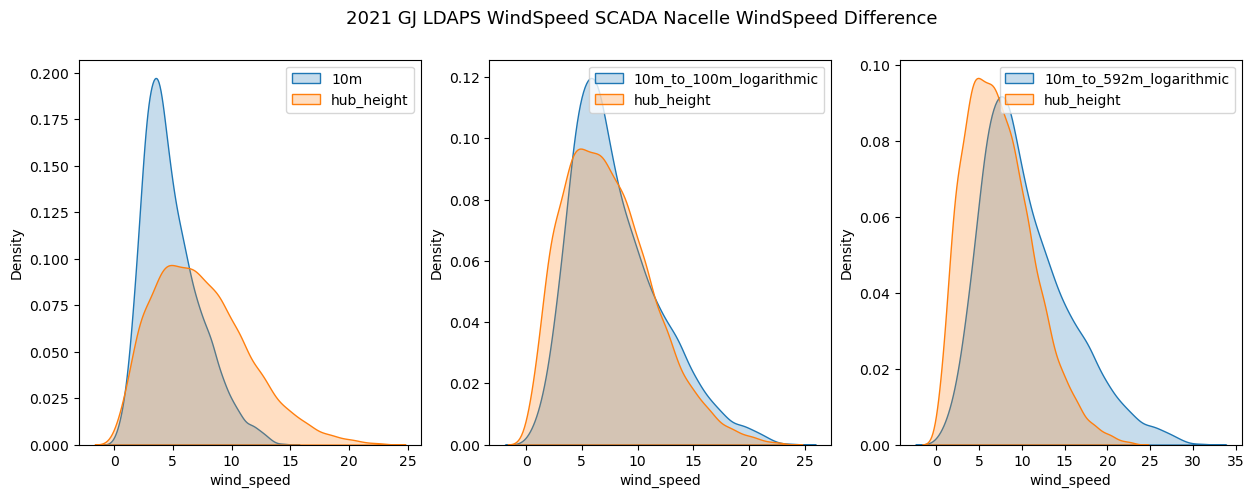

In [68]:
power2.rename({'WTG.Name': 'turbine_id'}, axis=1, inplace=True)
tmp = pd.merge(gj_y, power2,
               how='inner', on=['dt'])

tmp = pd.merge(tmp, ldaps,
               how='inner', on=['dt', 'turbine_id'])

tmp.head()

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
sns.kdeplot(data=tmp,
            x='wind_speed', label='10m',
            fill=True, ax=ax1)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True, ax=ax1)
ax1.legend()

log_speed = logarithmic_profile(tmp['wind_speed'], 10, 100, 0.286911)

ax2 = plt.subplot(1, 3, 2)
sns.kdeplot(x=log_speed, label='10m_to_100m_logarithmic',
            fill=True, ax=ax2)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True, ax=ax2)
ax2.legend()

log_speed = logarithmic_profile(tmp['wind_speed'], 10, 492 + 100, 0.286911)

ax3 = plt.subplot(1, 3, 3)
sns.kdeplot(x=log_speed, label='10m_to_592m_logarithmic',
            fill=True, ax=ax3)
sns.kdeplot(data=tmp,
            x='NacelleWindSpeed[m/s]', label='hub_height',
            fill=True, ax=ax3)
ax3.legend()

plt.suptitle("2021 GJ LDAPS WindSpeed SCADA Nacelle WindSpeed Difference", fontsize=13)
plt.show()

# wake loss 확인

In [94]:
ldaps[ldaps['wind_v_10m'] > 0].groupby('turbine_id')['wind_speed'].agg({'mean', 'median'})

,median,mean
turbine_id,,
WTG01,3.766476,4.278940
WTG02,3.231766,3.654032
WTG03,3.396858,3.775943
WTG04,3.396858,3.775943
WTG05,3.396858,3.775943
WTG06,3.396858,3.775943
WTG07,3.396858,3.775943
WTG08,3.496629,3.870936
WTG09,3.496629,3.870936


In [95]:
ldaps[ldaps['wind_v_10m'] < 0].groupby('turbine_id')['wind_speed'].agg({'mean', 'median'})

,median,mean
turbine_id,,
WTG01,4.990437,5.384251
WTG02,3.952269,4.309681
WTG03,3.865352,4.282964
WTG04,3.865352,4.282964
WTG05,3.865352,4.282964
WTG06,3.865352,4.282964
WTG07,3.865352,4.282964
WTG08,3.813313,4.274313
WTG09,3.813313,4.274313


In [143]:
x = ldaps.loc[(ldaps['turbine_id'] == 'WTG04') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'].values
y = ldaps.loc[(ldaps['turbine_id'] == 'WTG05') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'].values

sum(x - y)

0.0

<Axes: xlabel='wind_speed', ylabel='Density'>

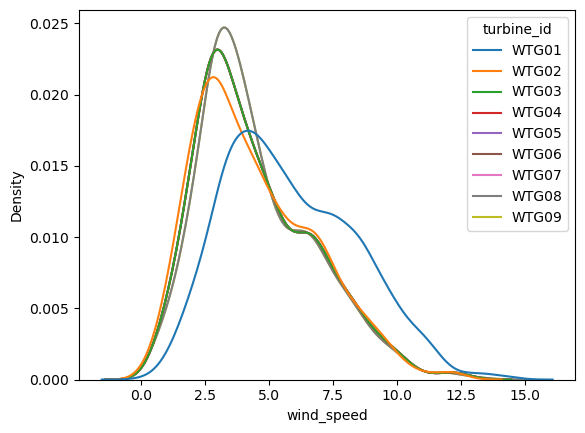

In [103]:
sns.kdeplot(data=ldaps[ldaps['dt'].dt.month.isin([12, 1, 2])],
            x='wind_speed', hue='turbine_id')

# 차이가 극명한 겨울로 확인

In [133]:
# from windpowerlib.wake_losses import reduce_wind_speed

# WTG01_wake_losses = reduce_wind_speed(ldaps.loc[(ldaps['turbine_id'] == 'WTG01') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'])
# WTG02_wake_losses = reduce_wind_speed(ldaps.loc[(ldaps['turbine_id'] == 'WTG02') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'])

# plt.figure(figsize=(15,7)) 
# ax1 = plt.subplot(1, 2, 1)
# sns.kdeplot(x=WTG01_wake_losses,
#             label='WTG01_WAKE',
#             fill=True,
#             ax=ax1)
# sns.kdeplot(x=ldaps.loc[(ldaps['turbine_id'] == 'WTG01') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'],
#             label='WTG01',
#             ax=ax1)
# sns.kdeplot(x=ldaps.loc[(ldaps['turbine_id'] == 'WTG02') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'],
#             label='WTG02',
#             fill=True,
#             ax=ax1)
# ax1.legend()

# ax2 = plt.subplot(1, 2, 2)
# sns.kdeplot(x=WTG02_wake_losses,
#             label='WTG02_WAKE',
#             fill=True,
#             ax=ax2)
# sns.kdeplot(x=ldaps.loc[(ldaps['turbine_id'] == 'WTG02') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'],
#             label='WTG02',
#             ax=ax2)
# sns.kdeplot(x=ldaps.loc[(ldaps['turbine_id'] == 'WTG03') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'],
#             label='WTG03',
#             fill=True,
#             ax=ax2)

# ax2.legend()
# plt.show()

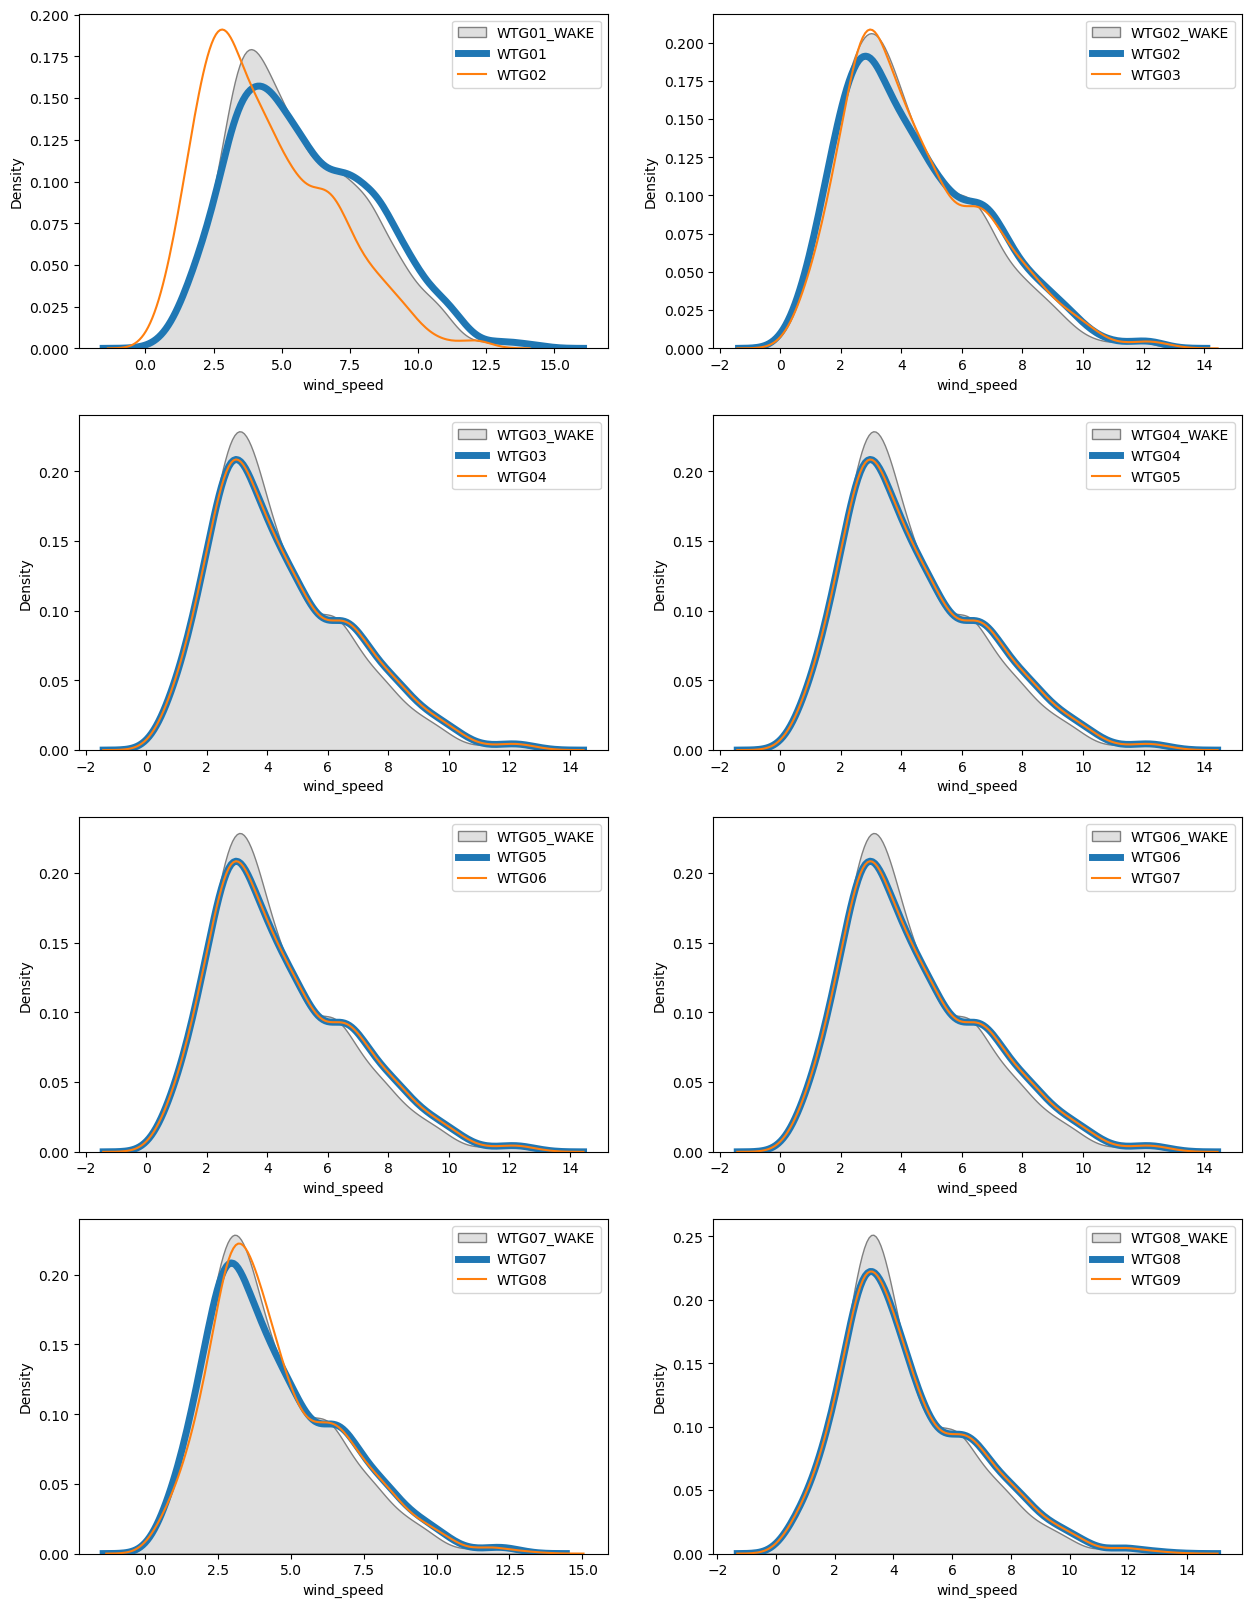

In [132]:
from windpowerlib.wake_losses import reduce_wind_speed

plt.figure(figsize=(15,20)) 

for i in range(1, 9):
    WTG_wake_losses = reduce_wind_speed(ldaps.loc[(ldaps['turbine_id'] == f'WTG0{i}') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'])
    ax = plt.subplot(4, 2, i)
    sns.kdeplot(x=WTG_wake_losses,
            label=f'WTG0{i}_WAKE',
            fill=True,
            color='gray',
            ax=ax)
    sns.kdeplot(x=ldaps.loc[(ldaps['turbine_id'] == f'WTG0{i}') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'],
                label=f'WTG0{i}',
                linewidth=5,
                ax=ax)
    sns.kdeplot(x=ldaps.loc[(ldaps['turbine_id'] == f'WTG0{i+1}') & (ldaps['dt'].dt.month.isin([12, 1, 2])), 'wind_speed'],
                label=f'WTG0{i+1}',
                fill=False,
                ax=ax)
    ax.legend()

plt.show()

# 기온 보정

In [164]:
from windpowerlib.temperature import linear_gradient

power = pd.read_parquet(INPUT_PATH + "dynamic_report_ewp02_2021_10min.parquet").rename({'Date/Time': 'dt'}, axis=1)
gj_y = pd.read_parquet(INPUT_PATH + "train_y.parquet").rename({'end_datetime': 'dt'}, axis=1)
ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")

print("Power: ", power.shape)
print("train_y: ", gj_y.shape)
print("LDAPS: ", ldaps.shape)

Power:  (52433, 29)
train_y:  (52608, 4)
LDAPS:  (235818, 15)


In [165]:
# data slicing
power = power[:-3]

datas = [power, gj_y, ldaps]
for d in datas:
    try:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_convert("Asia/Seoul"))
    except TypeError:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_localize("Asia/Seoul"))

gj_y = (gj_y.loc[(gj_y['plant_name'] == "경주풍력")
                 & (gj_y['dt']).between('2021-01-01', '2022-01-01', inclusive='left')])

ldaps = ldaps.loc[ldaps['dt'].between('2021-01-01', '2022-01-01', inclusive='left')]

print("Power: ", power.shape, power['dt'].min(), power['dt'].max())
print("train_y: ", gj_y.shape, gj_y['dt'].min(), gj_y['dt'].max())
print("LDAPS: ", ldaps.shape, ldaps['dt'].min(), ldaps['dt'].max())

Power:  (52430, 29) 2021-01-01 00:00:00+09:00 2021-12-31 23:50:00+09:00
train_y:  (8760, 4) 2021-01-01 00:00:00+09:00 2021-12-31 23:00:00+09:00
LDAPS:  (78831, 15) 2021-01-01 00:00:00+09:00 2021-12-31 23:00:00+09:00


In [166]:
ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
    ldaps["wind_u_10m"], ldaps["wind_v_10m"]
)

power.rename({'WTG.Name': 'turbine_id'}, axis=1, inplace=True)
tmp = pd.merge(gj_y, power,
               how='inner', on=['dt'])

tmp = pd.merge(tmp, ldaps,
               how='inner', on=['dt', 'turbine_id'])

tmp.head()

C:\Users\jhk32\AppData\Local\Temp\ipykernel_16720\209884163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
C:\Users\jhk32\AppData\Local\Temp\ipykernel_16720\209884163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(


,plant_name,dt,period_hours,energy_kwh,turbine_id,WTG.Serial,AvailabilityForcedOutageTime[Min.],AvailabilityFullPerformanceTime[Min.],AvailabilityRequestedShutdownTime[Min.],AvailabilityScheduledMaintenanceTime[Min.],...,pressure,relative_humid,specific_humid,temp_air,storm_u_5m,storm_v_5m,wind_u_10m,wind_v_10m,wind_speed,wind_direction
0,경주풍력,2021-01-01 00:00:00+09:00,1,17273.437500,WTG01,U113-001,0.0,10.0,0.0,0.0,...,97421.031250,98.096130,0.001953,264.102173,0.122864,-0.093026,3.172033,-1.847563,3.670869,300.218811
1,경주풍력,2021-01-01 01:00:00+09:00,1,18119.140625,WTG01,U113-001,0.0,10.0,0.0,0.0,...,97426.148438,101.684967,0.001953,263.825745,0.131611,-0.091649,3.589401,-1.373417,3.843186,290.938416
2,경주풍력,2021-01-01 02:00:00+09:00,1,17664.062500,WTG01,U113-001,0.0,10.0,0.0,0.0,...,97458.406250,103.387093,0.001953,263.540405,0.141142,-0.074264,3.666726,-1.218857,3.864000,288.387329
3,경주풍력,2021-01-01 03:00:00+09:00,1,17691.406250,WTG01,U113-001,0.0,10.0,0.0,0.0,...,97480.046875,93.023613,0.001709,263.773071,0.150186,-0.128167,5.362698,-1.853392,5.673939,289.065552
4,경주풍력,2021-01-01 04:00:00+09:00,1,15314.453125,WTG01,U113-001,0.0,10.0,0.0,0.0,...,97487.289062,91.892479,0.001709,263.556335,0.143697,-0.218682,5.573533,-1.976845,5.913729,289.528809


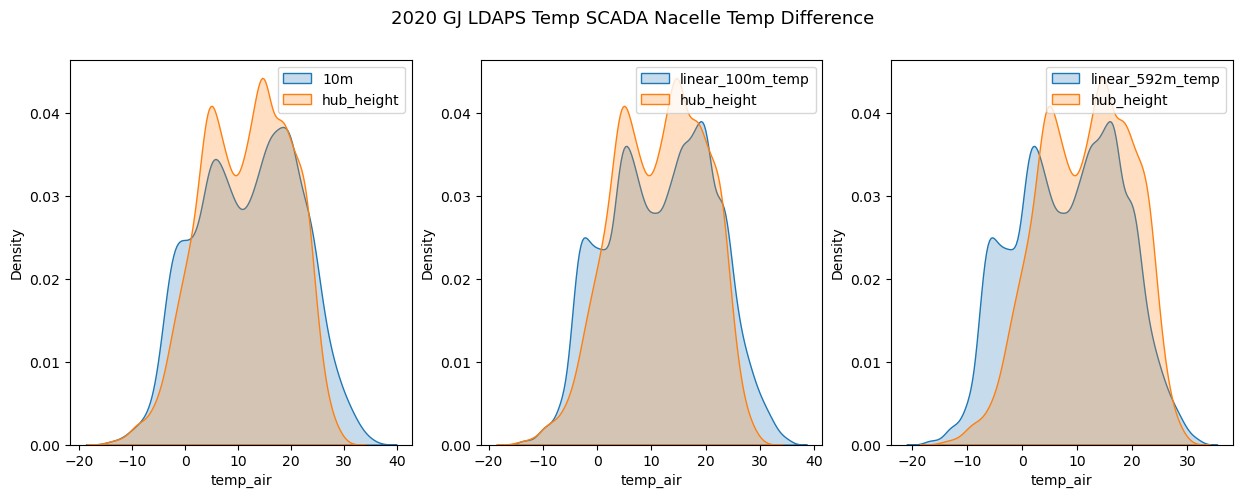

In [156]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 3, 1)
sns.kdeplot(x=tmp['temp_air'] - 273.15, label='10m',
            fill=True, ax=ax1)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True, ax=ax1)
ax1.legend()

hub_temperature = linear_gradient(ldaps['temp_air'], 0, 100)

ax2 = plt.subplot(1, 3, 2)
sns.kdeplot(x=hub_temperature - 273.15, label='linear_100m_temp',
            fill=True, ax=ax2)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True, ax=ax2)
ax2.legend()

hub_temperature = linear_gradient(ldaps['temp_air'], 0, 492 + 100)

ax3 = plt.subplot(1, 3, 3)
sns.kdeplot(x=hub_temperature - 273.15, label='linear_592m_temp',
            fill=True, ax=ax3)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True, ax=ax3)
ax3.legend()

plt.suptitle("2020 GJ LDAPS Temp SCADA Nacelle Temp Difference", fontsize=13)
plt.show()

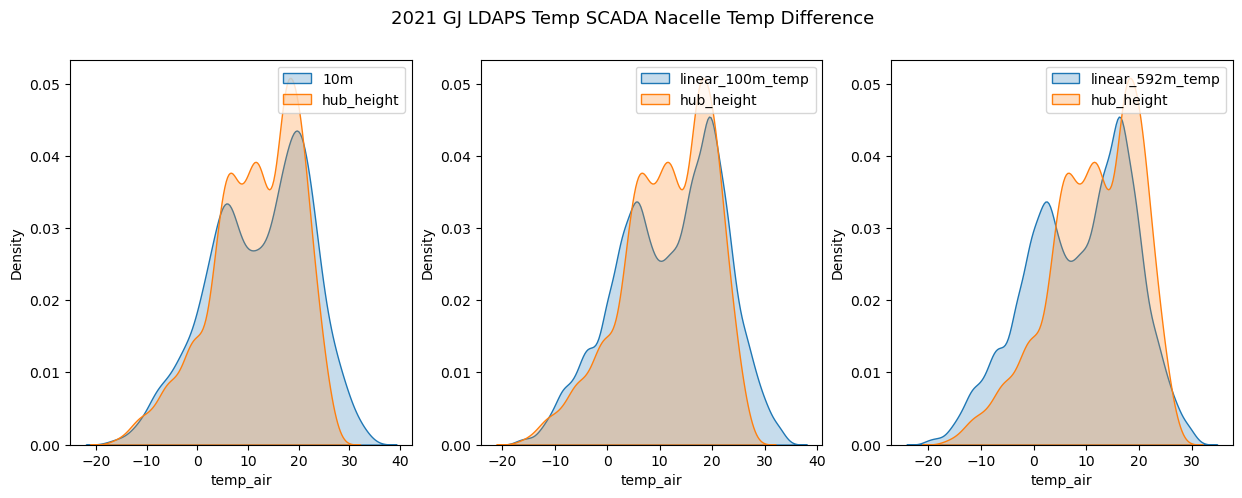

In [167]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 3, 1)
sns.kdeplot(x=tmp['temp_air'] - 273.15, label='10m',
            fill=True, ax=ax1)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True, ax=ax1)
ax1.legend()

hub_temperature = linear_gradient(ldaps['temp_air'], 0, 100)

ax2 = plt.subplot(1, 3, 2)
sns.kdeplot(x=hub_temperature - 273.15, label='linear_100m_temp',
            fill=True, ax=ax2)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True, ax=ax2)
ax2.legend()

hub_temperature = linear_gradient(ldaps['temp_air'], 0, 492 + 100)

ax3 = plt.subplot(1, 3, 3)
sns.kdeplot(x=hub_temperature - 273.15, label='linear_592m_temp',
            fill=True, ax=ax3)
sns.kdeplot(data=tmp,
            x='NacelleOutdoorTemp[℃]', label='hub_height',
            fill=True, ax=ax3)
ax3.legend()

plt.suptitle("2021 GJ LDAPS Temp SCADA Nacelle Temp Difference", fontsize=13)
plt.show()